In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM
from matplotlib.animation import FuncAnimation

In [ ]:
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline

# 1. Đọc dữ liệu

In [ ]:
!wget -O "VNI.csv" "https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%20Index%20Historical%20Data.csv"
!wget -O "VN30.csv" "https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%2030%20Historical%20Data.csv"
!wget -O "HNX.csv" "https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/HNX%20Historical%20Data.csv"
!wget -O "HNX30.csv" "https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/HNX%2030%20Historical%20Data.csv"

--2022-05-24 07:42:12--  https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%20Index%20Historical%20Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19677 (19K) [text/plain]
Saving to: ‘VNI.csv’

VNI.csv             100%[===================>]  19.22K  --.-KB/s    in 0s      

2022-05-24 07:42:12 (78.7 MB/s) - ‘VNI.csv’ saved [19677/19677]

--2022-05-24 07:42:13--  https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%2030%20Historical%20Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19749 

In [ ]:
index_list = ["VNI", "VN30", "HNX", "HNX30"]

In [ ]:
for index in index_list:
  globals()[index] = pd.read_csv(f"{index}.csv", parse_dates=['Date'], index_col='Date').filter(['Price'])
  globals()[index] = globals()[index].iloc[::-1]

In [ ]:
VNI["Price"] = pd.to_numeric(VNI["Price"].apply(lambda x: x.replace(",", "")))
VN30["Price"] = pd.to_numeric(VN30["Price"].apply(lambda x: x.replace(",", "")))

In [ ]:
VNI

,Price
Date,
2021-05-20,1278.22
2021-05-21,1283.93
2021-05-24,1297.98
2021-05-25,1308.58
2021-05-26,1316.70
...,...
2022-05-16,1171.95
2022-05-17,1228.37
2022-05-18,1240.76


# 2. Xây dựng mô hình

In [ ]:
!wget -O "VNI-1.csv" "https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%20Index%20Historical%20Data%20(1).csv"

--2022-05-23 14:54:13--  https://raw.githubusercontent.com/HungThinhLuu/OS_KSTN/master/VN%20Index%20Historical%20Data%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179322 (175K) [text/plain]
Saving to: ‘VNI-1.csv’

VNI-1.csv           100%[===================>] 175.12K  --.-KB/s    in 0.02s   

2022-05-23 14:54:13 (6.97 MB/s) - ‘VNI-1.csv’ saved [179322/179322]



In [ ]:
data = pd.read_csv("VNI-1.csv", parse_dates=['Date'], index_col='Date').filter(['Price'])
data["Price"] = pd.to_numeric(data["Price"].apply(lambda x: x.replace(",", "")))
data = data.iloc[::-1]
data

,Price
Date,
2012-05-21,448.02
2012-05-22,447.94
2012-05-23,436.75
2012-05-24,426.92
2012-05-25,437.38
...,...
2022-05-16,1171.95
2022-05-17,1228.37
2022-05-18,1240.76


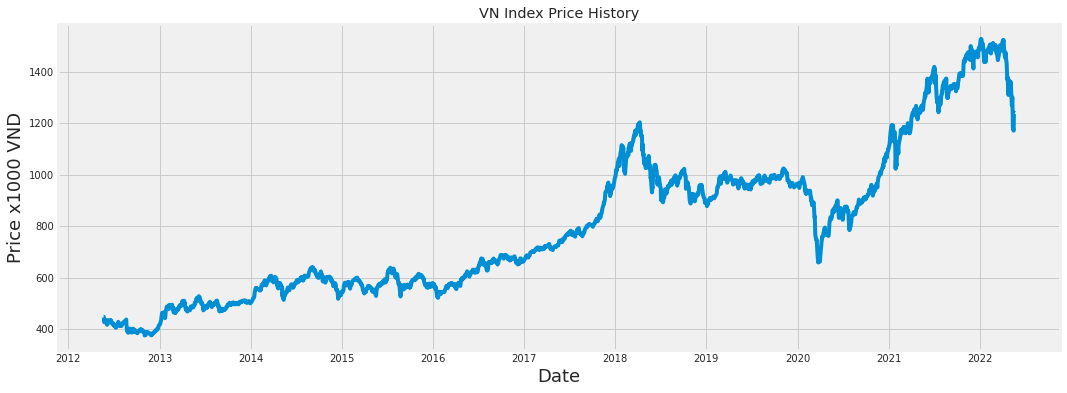

In [ ]:
plt.figure(figsize=(16,6))
plt.title('VN Index Price History')
plt.plot(data['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.show()

In [ ]:
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .9))
training_data_len

2248

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.06308798],
       [0.06301862],
       [0.05331611],
       ...,
       [0.75044871],
       [0.75121173],
       [0.75040536]])

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2188, 60, 1)

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2188/2188 [==============================] - 24s 8ms/step - loss: 0.0011


In [ ]:
model.save('stock_LSTM')

INFO:tensorflow:Assets written to: stock_LSTM/assets


INFO:tensorflow:Assets written to: stock_LSTM/assets


In [ ]:
!zip -r stock_LSTM.zip stock_LSTM

  adding: stock_LSTM/ (stored 0%)
  adding: stock_LSTM/keras_metadata.pb (deflated 90%)
  adding: stock_LSTM/variables/ (stored 0%)
  adding: stock_LSTM/variables/variables.index (deflated 65%)
  adding: stock_LSTM/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: stock_LSTM/saved_model.pb (deflated 90%)
  adding: stock_LSTM/assets/ (stored 0%)


# 3. Đánh giá mô hình

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

37.19959202136665

In [ ]:
dataset

array([[ 448.02],
       [ 447.94],
       [ 436.75],
       ...,
       [1240.76],
       [1241.64],
       [1240.71]])

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Price,Predictions
Date,,
2021-05-24,1297.98,1242.956055
2021-05-25,1308.58,1250.432739
2021-05-26,1316.70,1259.826904
2021-05-27,1303.57,1269.947998
2021-05-28,1320.46,1276.214111
...,...,...
2022-05-16,1171.95,1240.677612
2022-05-17,1228.37,1211.036255
2022-05-18,1240.76,1195.695435


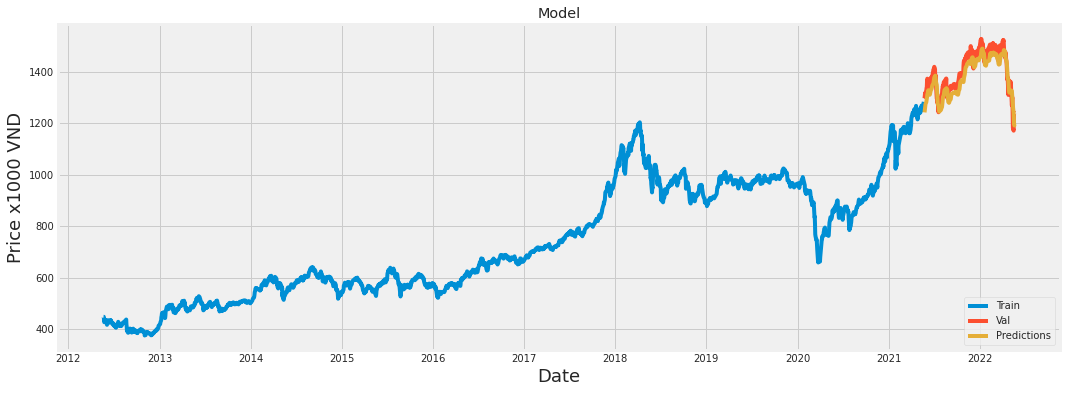

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price x1000 VND', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# 4. Đồ thị trực tiếp

In [ ]:
count = 100
len = VNI.shape[0]

In [ ]:
def animate(n):
  global count, axes
  for i, ax in enumerate(axes):
    ax.cla()
    if count >= len:
      ax.plot(globals()[index_list[i]]['Price'])
    else:
      ax.plot(globals()[index_list[i]].head(count)['Price'])
    ax.set_ylabel('Price')
    ax.set_xlabel(None)
    ax.set_title(f"Price of {index_list[i]}")
  count += 1

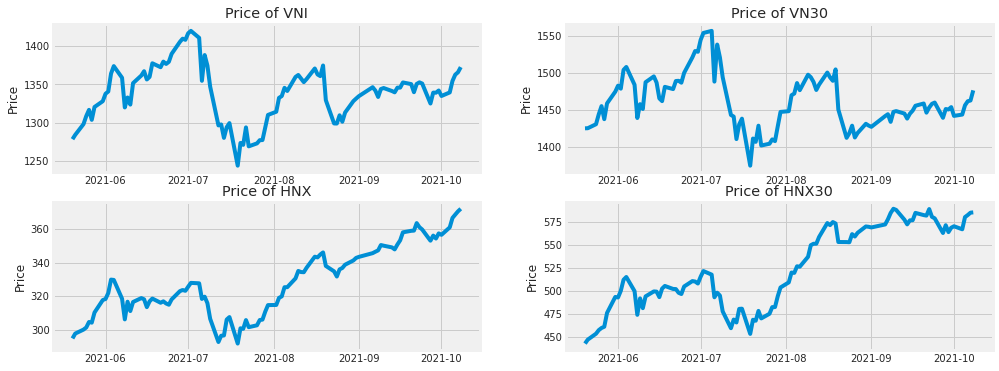

In [ ]:
fig = plt.figure(figsize=(15,6))
axes = [fig.add_subplot(2,2,1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,3), fig.add_subplot(2,2,4)]
ani = FuncAnimation(fig, animate, interval=500)
plt.show()